In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./utils")

from utils.skseq.sequences.sequence import Sequence
from utils.skseq.readers import pos_corpus
from utils.skseq.sequences.id_feature import IDFeatures
from skseq.sequences.extended_feature import ExtendedFeatures
import utils.skseq.sequences.structured_perceptron as spc
from utils.hmm import HMM, evaluate_hmm
import tqdm
import csv
from utils.utils import evaluate_corpus, show_confusion_matrix, get_f1_score, tiny_test

## Structured Perceptron

### Reading the data

In [3]:
corpus = pos_corpus.PostagCorpus()

In [4]:
data_path = "data/"

train_seq = corpus.read_sequence_list(data_path + "train_data_ner.csv")                                     
test_seq = corpus.read_sequence_list(data_path + "test_data_ner.csv")

In [5]:
print(len(train_seq))
print(len(test_seq))

38358
38359


### Feature mapper

In [6]:
feature_mapper = IDFeatures(train_seq)

feature_mapper.feature_dict

{}

In [7]:
# get features
feature_mapper.build_features()

len(feature_mapper.feature_dict), len(feature_mapper.feature_list)

(39801, 38358)

In [8]:
# show some features
list(feature_mapper.feature_dict)[0:10]

['init_tag:O',
 'id:Thousands::O',
 'id:of::O',
 'prev_tag:O::O',
 'id:demonstrators::O',
 'id:have::O',
 'id:marched::O',
 'id:through::O',
 'id:London::B-geo',
 'prev_tag:O::B-geo']

### Load model 

In [9]:
models_path = 'fitted_models/'

sp = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper)
sp.load_model(models_path + "perceptron_15_iter")

In [10]:
sp.parameters

array([ 8.      ,  8.133333, 12.266667, ...,  2.2     , -3.533333,
        0.333333])

### Evaluation (accuracy, f1 weighted score)

In [13]:
# Make predictions for the various sequences using the trained model.
pred_train = sp.viterbi_decode_corpus(train_seq)
pred_test  = sp.viterbi_decode_corpus(test_seq)

In [15]:
len(pred_train), len(pred_test)

(38358, 38359)

In [11]:
import pickle

#with open('pred_test', 'wb') as fp:
#    pickle.dump(pred_test, fp)

with open('predictions/pred_train', 'rb') as fp:
    pred_train = pickle.load(fp)
    
with open('predictions/pred_test', 'rb') as fp:
    pred_test = pickle.load(fp)

In [12]:
# Evaluate and print accuracies
eval_train = evaluate_corpus(train_seq.seq_list, pred_train)
eval_test = evaluate_corpus(test_seq.seq_list, pred_test)
print("SP -  Accuracy Train: %.4f Test: %.4f"%(eval_train, eval_test))

SP -  Accuracy Train: 0.8351 Test: 0.3219


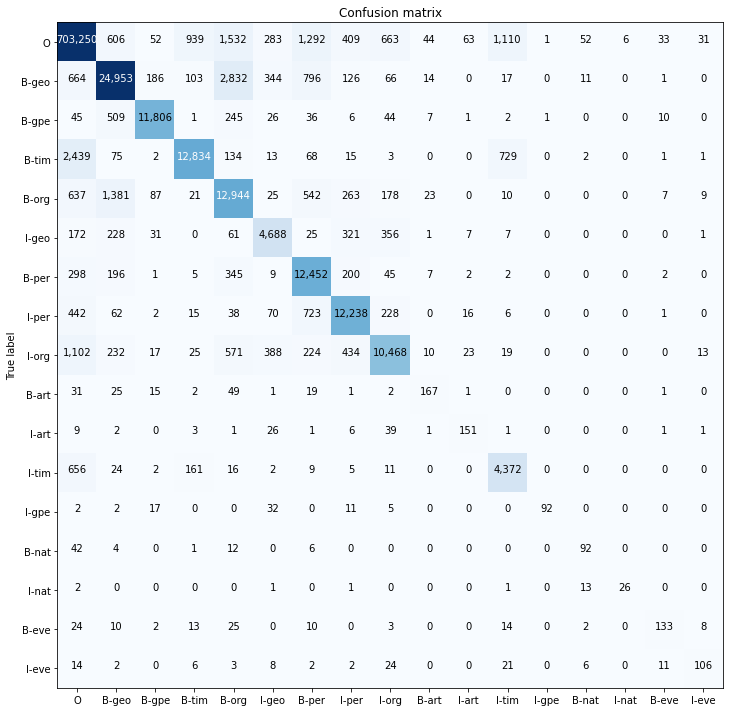

In [31]:
show_confusion_matrix(train_seq.seq_list, pred_train, sp)

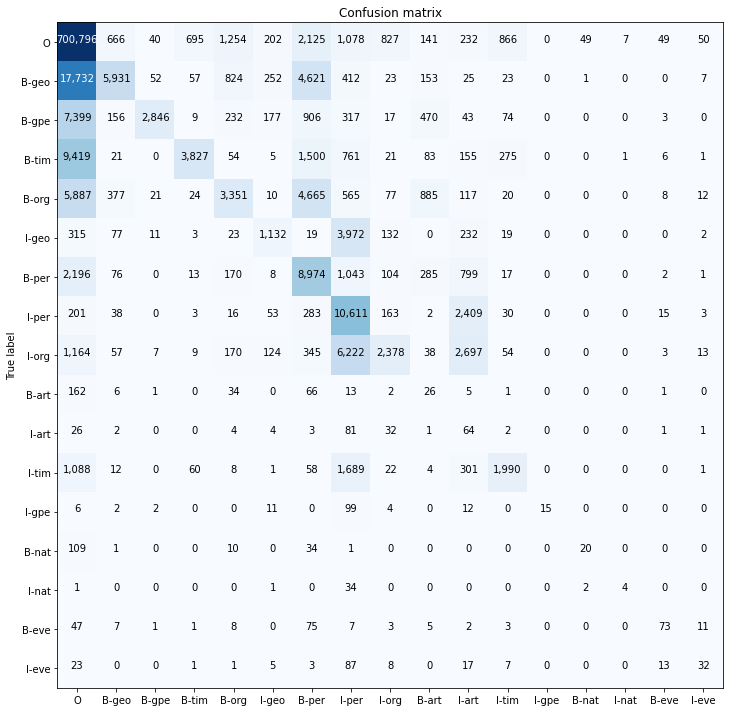

In [32]:
show_confusion_matrix(test_seq.seq_list, pred_test, sp)

In [113]:
round(get_f1_score(train_seq.seq_list, pred_train), 4)

0.9665

In [114]:
round(get_f1_score(test_seq.seq_list, pred_test), 4)

0.8711

In [19]:
tiny_test(sp, train_seq)

The/O programmers/O from/O Barcelona/B-org might/O write/O a/O sentence/O without/O a/O spell/B-per checker./I-per  

The/O programmers/O from/O Barchelona/B-per cannot/I-per write/O a/O sentence/O without/O a/O spell/B-per checker./I-per  

Jack/B-per London/B-geo went/O to/O Parris./O  

Jack/B-per London/B-geo went/O to/O Paris./O  

Bill/B-per gates/I-per and/O Steve/B-per jobs/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O  

Bill/B-per Gates/I-per and/O Steve/B-per Jobs/I-per never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O  

The/O president/O of/O U.S.A/O though/O they/O could/O win/O the/O war./O  

The/O president/O of/O the/O United/B-org States/I-org of/I-org America/I-org though/O they/O could/O win/O the/O war./O  

The/O king/O of/O Saudi/B-per Arabia/I-per wanted/O total/O control./O  

Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia./I-per  

Apple/O is/O a/O great/O company./O  

I/O really/O love/

In [21]:
#posterior decode gives the same accuracy
#tiny_test(sp, train_seq, decode="posterior")

In [15]:
sp.state_labels

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-geo': 5,
 'B-per': 6,
 'I-per': 7,
 'I-org': 8,
 'B-art': 9,
 'I-art': 10,
 'I-tim': 11,
 'I-gpe': 12,
 'B-nat': 13,
 'I-nat': 14,
 'B-eve': 15,
 'I-eve': 16}

### Extended features

In [6]:
feature_mapper = ExtendedFeatures(train_seq)
feature_mapper.feature_dict

{}

In [7]:
# get features
feature_mapper.build_features()

len(feature_mapper.feature_dict), len(feature_mapper.feature_list)

(54286, 38358)

In [10]:
models_path = 'fitted_models/'

sp = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper)
sp.load_model(models_path + "perceptron_10_iter_extended")

In [11]:
sp.parameters

array([10.6,  2.8,  2.6, ..., -9.6,  1.9,  1.9])

### Evaluation (accuracy, f1 weighted score)

In [12]:
# Make predictions for the various sequences using the trained model.
pred_train = sp.viterbi_decode_corpus(train_seq)
pred_test  = sp.viterbi_decode_corpus(test_seq)

100%|██████████| 38359/38359 [05:51<00:00, 109.13it/s]


In [13]:
len(pred_train), len(pred_test)

(38358, 38359)

In [14]:
import pickle

with open('predictions/pred_test_extended', 'wb') as fp:
    pickle.dump(pred_test, fp)
    
with open('predictions/pred_train_extended', 'wb') as fp:
    pickle.dump(pred_train, fp)

#with open('pred_train', 'rb') as fp:
#    pred_train = pickle.load(fp)
    
#with open('pred_test', 'rb') as fp:
#    pred_test = pickle.load(fp)

In [15]:
# Evaluate and print accuracies
eval_train = evaluate_corpus(train_seq.seq_list, pred_train)
eval_test = evaluate_corpus(test_seq.seq_list, pred_test)
print("SP -  Accuracy Train: %.3f Test: %.3f"%(eval_train, eval_test))

SP -  Accuracy Train: 0.810 Test: 0.422


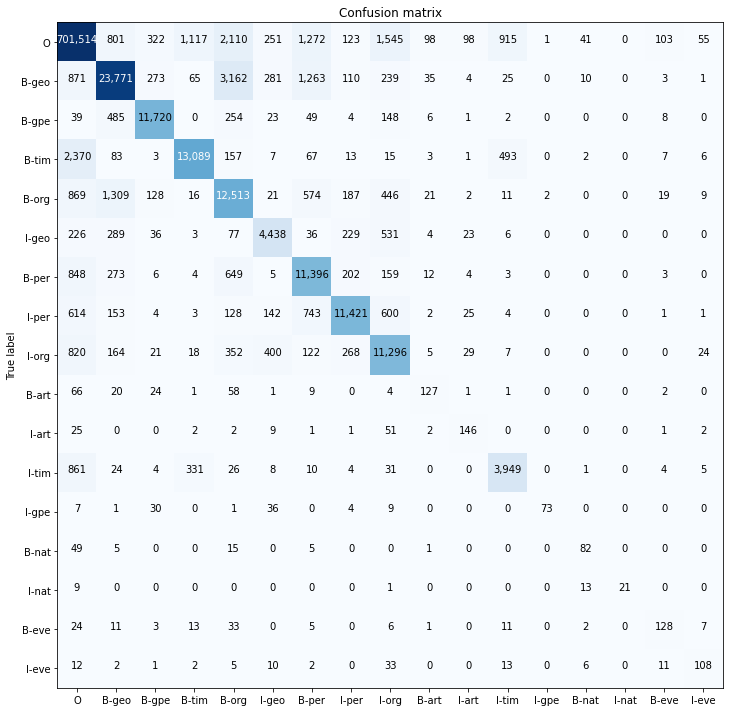

In [17]:
show_confusion_matrix(train_seq.seq_list, pred_train, sp)

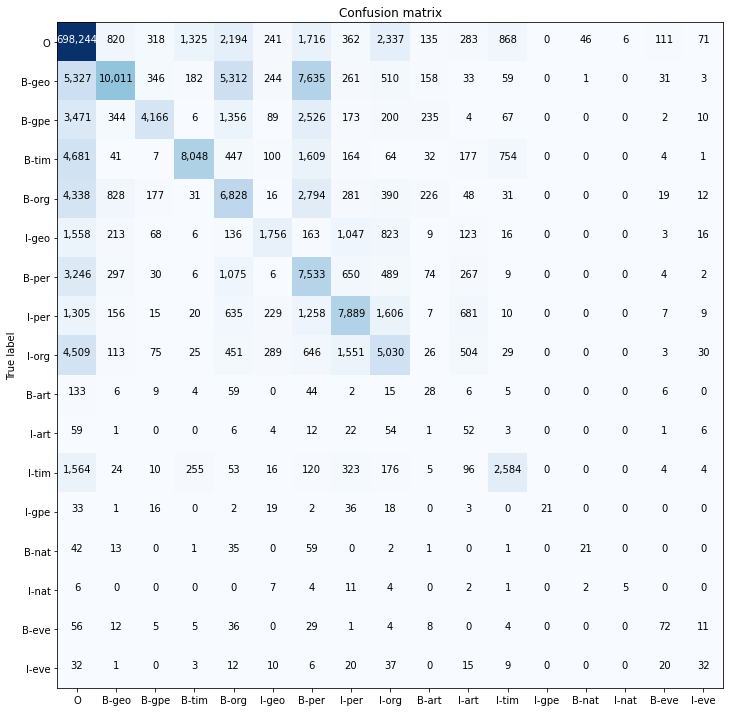

In [18]:
show_confusion_matrix(test_seq.seq_list, pred_test, sp)

In [19]:
round(get_f1_score(train_seq.seq_list, pred_train), 4)

0.9608

In [20]:
round(get_f1_score(test_seq.seq_list, pred_test), 4)

0.8945

In [21]:
tiny_test(sp, train_seq)

The/O programmers/O from/O Barcelona/B-per might/O write/O a/O sentence/O without/O a/O spell/O checker./B-per  

The/O programmers/O from/O Barchelona/B-per cannot/I-per write/O a/O sentence/O without/O a/O spell/O checker./B-per  

Jack/B-per London/B-geo went/O to/O Parris./B-per  

Jack/B-per London/B-geo went/O to/O Paris./B-per  

Bill/B-per gates/O and/O Steve/B-per jobs/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./B-per  

Bill/B-per Gates/I-per and/O Steve/B-per Jobs/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company./B-per  

The/O president/O of/O U.S.A/B-org though/O they/O could/O win/O the/O war./B-per  

The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war./B-per  

The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./B-per  

Robin/B-per does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia./I-per  

Apple/O is/O a/O great/O company./B-p

### HMM 

In this section we check the results for an HMM with posterior decoding. The interest of such a model is that, being generative, its features are less informative and it cannot take OOV words into account, so it serves to illustrate the advantages of the structured perceptron and other discriminative approaches.

The class and required functions for the HMM are in **utils/hmm.py**. We have completed and adapted the code provided in class (namely, the functions for counting, computing forward and backward tables, and decoding. obtaining the same results for the conll datasets).

As recommended, we include the computation of the predictions for train (1h) and test (30min) in this notebook, and not in **train_models.ipynb**. Since fitting the model takes only 2 seconds, we have decided to include that step here as well, rather than fitting in **train_models.ipynb**, saving the class instance and loading it here (which is less practical in this case).

Mapping words and states to positions:

In [22]:
ind_to_word  = {v: k for k, v in train_seq.x_dict.items()}
ind_to_state = {v: k for k, v in train_seq.y_dict.items()}
word_to_ind  = train_seq.x_dict
state_to_ind = train_seq.y_dict

Train values:

In [23]:
X = []
Y = []
for i in range(len(train_seq)):
    xy = train_seq[i]
    X.append([ind_to_word[x_i] for x_i in xy.x])
    Y.append([ind_to_state[y_i] for y_i in xy.y])

Test values:

In [24]:
X_test = []
Y_test = []
for i in range(len(test_seq)):
    xy = test_seq[i]
    X_test.append([ind_to_word[x_i] for x_i in xy.x])
    Y_test.append([ind_to_state[y_i] for y_i in xy.y])

Now we fit our HMM:

In [25]:
hmm = HMM(word_to_ind, state_to_ind)
hmm.fit(X, Y)

/home/bambusito/Desktop/backup/Dropbox/masterBCN/NLP/Assignments/NLP-NER/utils/hmm.py:168: RuntimeWarning: divide by zero encountered in log
  return {"emission":   np.log(probs["emission"]),
/home/bambusito/Desktop/backup/Dropbox/masterBCN/NLP/Assignments/NLP-NER/utils/hmm.py:169: RuntimeWarning: divide by zero encountered in log
  "transition": np.log(probs["transition"]),
/home/bambusito/Desktop/backup/Dropbox/masterBCN/NLP/Assignments/NLP-NER/utils/hmm.py:170: RuntimeWarning: divide by zero encountered in log
  "final":      np.log(probs["final"]),
/home/bambusito/Desktop/backup/Dropbox/masterBCN/NLP/Assignments/NLP-NER/utils/hmm.py:171: RuntimeWarning: divide by zero encountered in log
  "initial":    np.log(probs["initial"])}


Predictions are easily drawn and, unlike for the structured perceptron, input and output are direcly in words:

In [26]:
y_hat = hmm.predict_labels(X[0])

In [27]:
y_hat[10:15], Y[0][10:15]

(['O', 'O', 'B-geo', 'O', 'O'], ['O', 'O', 'B-geo', 'O', 'O'])

Let us now go fot the whole train and test datasets. They take us a while (roughly 1h and 30min), so we saved the predictions (see below) in case you don't want to rerun them:

In [23]:
Y_hat = []
for x in tqdm.tqdm(X):
    Y_hat.append(hmm.predict_labels(x))

100%|██████████| 38358/38358 [54:05<00:00, 11.82it/s]  


In [19]:
Y_test_hat = []
for x in tqdm.tqdm(X_test):
    Y_test_hat.append(hmm.predict_labels(x))

100%|██████████| 38359/38359 [30:48<00:00, 20.75it/s] 


Save train and test predictions:

In [16]:
# save preds to csv
fname = 'predictions/hmm_pred_train.csv'
#with open(fname, 'w', newline='') as f:  # uncomment if you really want to save some preds
    writer = csv.writer(f)
    writer.writerows(Y_hat)
    
fname = 'predictions/hmm_pred_test.csv'
#with open(fname, 'w', newline='') as f: # uncomment if you really want to save some preds
    writer = csv.writer(f)
    writer.writerows(Y_test_hat)

Load predictions:

In [28]:
# read csv files as nested lists
fname = 'predictions/hmm_pred_train.csv'
with open(fname, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = csv.reader(read_obj)
    # Pass reader object to list() to get a list of lists
    Y_hat = list(csv_reader)
    
fname = 'predictions/hmm_pred_test.csv'
with open(fname, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = csv.reader(read_obj)
    # Pass reader object to list() to get a list of lists
    Y_test_hat = list(csv_reader)

Evaluation. Get accuracies (without counting true "O"s -outside-):

In [29]:
#train
evaluate_hmm(Y, Y_hat, ignore_O=True)
#test
evaluate_hmm(Y_test, Y_test_hat, ignore_O=True)

Accuracy of posterior decode ignoring 'O' tags: 0.8626
Accuracy of posterior decode ignoring 'O' tags: 0.1449


Very low test accuracy!

Confusion matrices:

In [30]:
pos = list(state_to_ind.values())
labs = list(state_to_ind.keys())

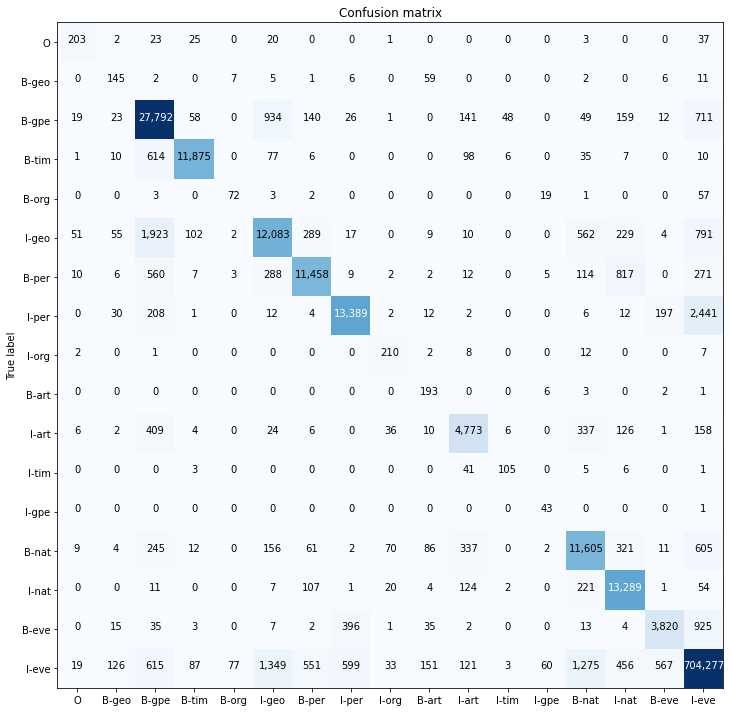

In [31]:
#train
show_confusion_matrix(Y, Y_hat, positions=pos, labels=labs#[::-1]
                      , hmm=True)

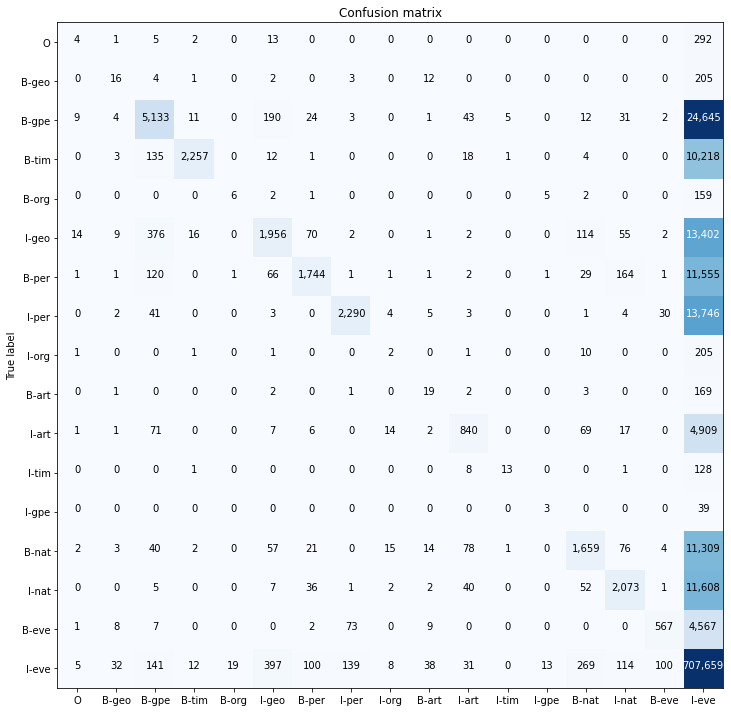

In [32]:
#test
show_confusion_matrix(Y_test, Y_test_hat, positions=pos, labels=labs#[::-1]
                      , hmm=True)

Something's off with the axes of the confusion matrices: counts don't correspond to true values (check e.g. for "O": all entries of the row -true value- in the test confusion matrix should add up to 709077, as shown below):

In [41]:
tag_counts = {}

for i, seq  in enumerate(Y_test):
    for j, t in enumerate(seq):
        tag_counts[t] = tag_counts.get(t, 0) + 1

tag_counts

{'B-gpe': 12649,
 'O': 709077,
 'B-tim': 16129,
 'B-org': 16019,
 'B-geo': 30113,
 'B-per': 13688,
 'I-per': 13827,
 'I-tim': 5234,
 'B-art': 317,
 'I-geo': 5937,
 'B-nat': 175,
 'I-org': 13281,
 'I-nat': 42,
 'B-eve': 243,
 'I-art': 221,
 'I-eve': 197,
 'I-gpe': 151}

Unfortunately, we haven't been able to identify and correct the bug.

In any case, the confusion matrix for test reveals that not only most words are being tagged "O", but also that most wrongly tagged words are identified as "O" (as shown by the vertical column that obviously corresponds to that predicted category). Indeed, if we include true "O"s when computing accuracy, we get a much better result at test:

In [34]:
#train
evaluate_hmm(Y, Y_hat, ignore_O=False)
#test
evaluate_hmm(Y_test, Y_test_hat, ignore_O=False)

Accuracy of posterior decode counting 'O' tags: 0.9717
Accuracy of posterior decode counting 'O' tags: 0.8674


Weighted f-scores:

In [161]:
#train
round(get_f1_score(Y, Y_hat, hmm=True), 4)

0.9717

In [162]:
#test
round(get_f1_score(Y_test, Y_test_hat, hmm=True), 4)

0.8242

Why is the HMM performing so bad at test? We don't think the reason to be a bug in the code, because we cross-checked results for the conll datasets with those provided. Alternatively, one could attribute this poor performance to the presence of OOV words being wrongly tagged as "O". However, such cannot be the case, as train and test datasets have the same words:

In [43]:
train_seq.x_dict.keys() == test_seq.x_dict.keys()

True

Besides, if any new word is encountered by the HMM, it will print the word and do some smoothing to prevent an error (as happens with the tiny test; see below) which did not happen when predicting at test.

This, together with the result for the confusion matrix, tells us what has happened: at test, most non-"O" words are tagged "O" not because of their being OOV but probably because of the lesser information contained in the limited features of the HMM (compared to discriminative models). Words are likely to be assigned the most frequent tag at train ("O", 85% of total counts). As the test dataset is also mostly "O"s (85% as well), the effect of false "O"s is little when considering all tags, but when barring out uninteresting tags we get the false "O"s as errors without getting the true ones as right, giving the very low accuracy of 0.14.

Let us now check the results for the tiny test. As we have mentioned, we have added some smoothing to prevent an error in the emission scores of OOV words when computing the forward and backward tables: for any OOV word, we print it and assign the same emission probability to all states/labels.

In [44]:
tiny_test(hmm, hmm=True, state_to_pos=state_to_ind)

spell is OOV
checker. is OOV
spell is OOV
checker. is OOV
The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O  

Barchelona is OOV
cannot is OOV
spell is OOV
checker. is OOV
Barchelona is OOV
cannot is OOV
spell is OOV
checker. is OOV
The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/O checker./O  

Parris. is OOV
Parris. is OOV
Jack/B-per London/B-geo went/O to/O Parris./O  

Paris. is OOV
Paris. is OOV
Jack/B-per London/B-geo went/O to/O Paris./O  

company. is OOV
company. is OOV
Bill/B-per gates/O and/O Steve/B-per jobs/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O  

Jobs is OOV
Microsof is OOV
company. is OOV
Jobs is OOV
Microsof is OOV
company. is OOV
Bill/B-per Gates/I-per and/O Steve/B-per Jobs/I-per never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O  

war. is OOV
war. is OOV
The/O president/O of/O U.S.A/O though/O they/O cou

This is unexpected: the acuracy at tiny test is better for the HMM than for the SP! Considering that this dataset does contain many OOV words, we find two possible reasons for such a result: 1) Our manual "true" tagging is flawed and hence the resulting tiny test accuracies should be taken with a grain of salt; 2) the tiny test dataset is too tiny to yield representative results, the above being a statistic fluctuation. We suspect the real cause to be a combination of the two.

Therefore, regardless of the results of the tiny test, we conclude that the greater generality of feature representations of discriminative models such as the SP tends to yield better performance when compared to HMM approaches, as shown by the evalutation with the large test dataset.